In [1]:
import gensim
##import gensim.corpora as corpora
##from gensim.utils import simple_preprocess
##from gensim.models import CoherenceModel
##from gensim.models import Word2Vec
import gensim.downloader as api

pretrained_model = api.load('glove-twitter-50')

## Defining some auxiliary functions

In [40]:
import json 
import timeit
import numpy as np
import matplotlib.pyplot as plt

def plot_graph_(dst, 
                txtrk,
                rake,
                tfidf, 
                lda,
                gsdmm,
                title, 
                limit, 
                start, 
                step):
    plt.clf()
    x = range(start, limit, step)
    
    if (title.find('runtime') != -1): 
        dst = [x + 1.68 for x in dst] #0.68 is the average time for sampling by VAE/GAN and mass inferring by DST's rule of combination
        
    # plotting the line 1 points    
    plt.plot(x, dst, marker='o', label = "dst")
    plt.plot(x, txtrk, marker='v', label = "txtrk")
    plt.plot(x, rake, marker='^', label = "rake")
    plt.plot(x, tfidf, marker='s', label = "tfidf")
    plt.plot(x, lda, marker='D', label = "lda")
    plt.plot(x, gsdmm, marker='*', label = "gsdmm")
    
    plt.xlabel('Profile Length - n')
    
    if (title.find('runtime') != -1): 
        plt.ylabel('Average Runtime in seconds at n')
        fig_name = 'fb_runtime'
    
    if (title.find('precision') != -1): 
        plt.ylabel('Average Precision at n (in 10^-1)')
        fig_name = 'fb_precision'
    
    if (title.find('MRR') != -1): 
        plt.ylabel('MRR at n (in 10^-1)')
        fig_name = 'fb_MRR'
    
    if (title.find('MAP') != -1): 
        plt.ylabel('MAP at n (in 10^-1)')
        fig_name = 'fb_MAP'
    
    if (title.find('semantic') != -1): 
        plt.ylabel('Average Semantic Precision at n (in 10^-1)')
        fig_name = 'fb_semantic'
        
    # Set a title of the current axes.
    plt.title(title)
    # show a legend on the plot
    plt.legend(ncol=2)
    #save the figure
    plt.savefig(fig_name + '.pdf')
    #display a figure.
    plt.show()
    #close the figure
    plt.close()
    
    return 1


def load_data_from_file(filename):
    data = []
    with open(filename,'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
        f.close()
        
    hashtags = data[0]
    dst = data[1]
    txtrk = data[2]
    rake = data[3]
    tfidf = data[4]
    lda = data[5]
    gsdmm = data[6]
    
    return hashtags, dst, txtrk, rake, tfidf, lda, gsdmm

def average_list_of_list(a):
    #print(a)
    return list(np.sum(a, axis = 0) / len(a) + 1.68)

def evaluate_runtime(dst_lst, txtrk_lst, rake_lst, tfidf_lst, lda_lst, gsdmm_lst):
    
    avg_rt_dst = []
    avg_rt_txtrk = []
    avg_rt_rake = []
    avg_rt_tfidf = []
    avg_rt_lda = []
    avg_rt_gsdmm = []
    
    for i in range(0, len(txtrk_lst)):
        num_window_of_aUser = len(txtrk_lst[i])
        for j in range (0, num_window_of_aUser):

            #extract runtime of dst
            rt_dst = dst_lst[i][j][len(dst_lst[i][j]) - 1]
            tmp = [(x/100 * rt_dst) for x in range(5, 51, 5)]
            avg_rt_dst.append(tmp)
            #print("rt_dst = ", tmp)
  
            #extract runtime of txtrk
            rt_txtrk = txtrk_lst[i][j][len(txtrk_lst[i][j]) - 1]
            avg_rt_txtrk.append(rt_txtrk)
            
            #extract runtime of rake
            rt_rake = rake_lst[i][j][len(rake_lst[i][j]) - 1]
            #print("rt_rake = ", rt_rake)
            avg_rt_rake.append(rt_rake)
            
            #extract runtime of tfidf
            rt_tfidf = tfidf_lst[i][j][len(tfidf_lst[i][j]) - 1]
            #print("rt_tfidf = ", rt_tfidf)
            avg_rt_tfidf.append(rt_tfidf)
            
            #extract runtime of lda
            rt_lda = lda_lst[i][j][len(lda_lst[i][j]) - 1]
            #print("rt_lda = ", rt_lda)
            avg_rt_lda.append(rt_lda)
            
            #extract runtime of gsdmm
            rt_gsdmm = gsdmm_lst[i][j][len(gsdmm_lst[i][j]) - 1]
            #print("rt_gsdmm = ", rt_gsdmm)
            avg_rt_gsdmm.append(rt_gsdmm)

    avg_rt_dst = average_list_of_list(avg_rt_dst)      
    avg_rt_txtrk = average_list_of_list(avg_rt_txtrk)
    avg_rt_rake = average_list_of_list(avg_rt_rake)
    avg_rt_tfidf = average_list_of_list(avg_rt_tfidf)
    avg_rt_lda = average_list_of_list(avg_rt_lda)
    avg_rt_gsdmm = average_list_of_list(avg_rt_gsdmm)
    
    return avg_rt_dst, avg_rt_txtrk, avg_rt_rake, avg_rt_tfidf, avg_rt_lda, avg_rt_gsdmm

def my_cosine(a, b):
    dot = np.dot(a, b)
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    cos = dot / (norma * normb)
    
    return cos

def calculate_semantic_at_K(ground_truths, user_keywords, pretrained_model):
    
    all_keyword_cosine = [] 
    for keyword in user_keywords:
        tmp_cosine = 0
        for word in ground_truths:
            if keyword in pretrained_model and keyword in pretrained_model:
                tmp_cosine += my_cosine(np.array(pretrained_model[keyword]), 
                                        np.array(pretrained_model[word]))
        all_keyword_cosine.append(tmp_cosine/len(ground_truths))
        
    return np.sum(all_keyword_cosine)/len(all_keyword_cosine)

def semantic_one_batch(lst, ground_truths, pretrained_model):
    #print("(lst) = ", (lst))
    #print("(lst 0) = ", (lst[0]))
    #print("(lst 1) = ", (lst[1]))
    #print("(lst 2) = ", (lst[2]))

    res_lst = []
    for i in range (0, len(lst)):
        tmp = calculate_semantic_at_K(ground_truths, lst[i], pretrained_model)
        res_lst.append(tmp)
    #print("res_lst =", res_lst)   
    return res_lst

def evaluate_semantic(dst_lst, txtrk_lst, rake_lst, tfidf_lst, lda_lst, gsdmm_lst, pretrained_model):
    
    avg_semantic_dst = []
    avg_semantic_txtrk = []
    avg_semantic_rake = []
    avg_semantic_tfidf = []
    avg_semantic_lda = []
    avg_semantic_gsdmm = []
    
    for i in range(0, len(txtrk_lst)):
        num_window_of_aUser = len(txtrk_lst[i])
        
        for j in range (0, num_window_of_aUser):

            #DST model: calculate semantic at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_dst = dst_lst[i][j][len(dst_lst[i][j]) - 2]
            profile_dst = dst_lst[i][j][0]
            #print("ground_truth = ", ground_truth_dst)
            #tmp = [(x/100 * semantic_dst) for x in range(5, 51, 5)]
            semantic_dst_lst = []
            for k in range (5, 51, 5):
                #Calculate semantic at K
                semantic_at_K_dst = calculate_semantic_at_K(ground_truths = ground_truth_dst, 
                                                            user_keywords = profile_dst[:k], 
                                                            pretrained_model = pretrained_model)
                #print("profile_dst at " + str(k) + " = ", profile_dst[:k])
                #print("semantic at k = ", semantic_at_K_dst)
                semantic_dst_lst.append(semantic_at_K_dst)
                
            avg_semantic_dst.append(semantic_dst_lst)
  
            #Txtrk model: calculate semantic at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_txtrk = txtrk_lst[i][j][len(txtrk_lst[i][j]) - 2]
            #print("ground_truth_txtrk = ", ground_truth_txtrk)
            avg_semantic_txtrk.append(semantic_one_batch(lst = txtrk_lst[i][j][:len(txtrk_lst[i][j]) - 2], 
                                                         ground_truths = ground_truth_txtrk, 
                                                         pretrained_model = pretrained_model))
            
            
            #RAKE model: calculate semantic at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_rake = rake_lst[i][j][len(rake_lst[i][j]) - 2]
            #print("ground_truth_rake = ", ground_truth_rake)
            avg_semantic_rake.append(semantic_one_batch(lst = rake_lst[i][j][:len(rake_lst[i][j]) - 2], 
                                                        ground_truths = ground_truth_rake, 
                                                        pretrained_model = pretrained_model))
            
            #TFIDF model: calculate semantic at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_tfidf = tfidf_lst[i][j][len(tfidf_lst[i][j]) - 2]
            #print("ground_truth_tfidf = ", ground_truth_tfidf)
            avg_semantic_tfidf.append(semantic_one_batch(lst = tfidf_lst[i][j][:len(tfidf_lst[i][j]) - 2], 
                                                         ground_truths = ground_truth_tfidf, 
                                                         pretrained_model = pretrained_model))
            
            
            #LDA model: calculate semantic at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_lda = lda_lst[i][j][len(lda_lst[i][j]) - 2]
            #print("ground_truth_tfidf = ", ground_truth_lda)
            avg_semantic_lda.append(semantic_one_batch(lst = lda_lst[i][j][:len(lda_lst[i][j]) - 2], 
                                                       ground_truths = ground_truth_lda, 
                                                       pretrained_model = pretrained_model))
            
            #GSDMM model: calculate semantic at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_gsdmm = gsdmm_lst[i][j][len(gsdmm_lst[i][j]) - 2]
            #print("ground_truth_tfidf = ", ground_truth_gsdmm)
            avg_semantic_gsdmm.append(semantic_one_batch(lst = gsdmm_lst[i][j][:len(gsdmm_lst[i][j]) - 2], 
                                                         ground_truths = ground_truth_gsdmm, 
                                                         pretrained_model = pretrained_model))
            

    avg_semantic_dst = average_list_of_list(avg_semantic_dst)      
    avg_semantic_txtrk = average_list_of_list(avg_semantic_txtrk)
    avg_semantic_rake = average_list_of_list(avg_semantic_rake)
    avg_semantic_tfidf = average_list_of_list(avg_semantic_tfidf)
    avg_semantic_lda = average_list_of_list(avg_semantic_lda)
    avg_semantic_gsdmm = average_list_of_list(avg_semantic_gsdmm)
    
    return avg_semantic_dst, avg_semantic_txtrk, avg_semantic_rake, avg_semantic_tfidf, avg_semantic_lda, avg_semantic_gsdmm

def calculate_precision_at_K(labels, keywords):
    precision = 0
    #print("labels = ", labels)
    #print("user_keywords = ", user_keywords)


    #print('\n')
    for keyword in keywords:
        for label in labels:
            if label.lower().find(keyword.lower()) != -1:
                precision += 1
                #print(keyword, " is correct")
                #print("label = ", label)
                #print("keyword = ", keyword)
                #print("keyword " + keyword.lower() + " is in hashtags")
                break
     
    return precision/len(keywords)

def precision_one_batch(lst, ground_truths):
    #print("(lst) = ", (lst))
    #print("(lst 0) = ", (lst[0]))
    #print("(lst 1) = ", (lst[1]))
    #print("(lst 2) = ", (lst[2]))

    res_lst = []
    for i in range (0, len(lst)):
        tmp = calculate_precision_at_K(labels = ground_truths, keywords = lst[i])
        res_lst.append(tmp)
    #print("res_lst =", res_lst)   
    return res_lst

def evaluate_standard_precision(dst_lst, txtrk_lst, rake_lst, tfidf_lst, lda_lst, gsdmm_lst):
    
    avg_precision_dst = []
    avg_precision_txtrk = []
    avg_precision_rake = []
    avg_precision_tfidf = []
    avg_precision_lda = []
    avg_precision_gsdmm = []
    
    for i in range(0, len(txtrk_lst)):
        num_window_of_aUser = len(txtrk_lst[i])
        
        for j in range (0, num_window_of_aUser):

            #DST model: calculate standard precision at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_dst = dst_lst[i][j][len(dst_lst[i][j]) - 2]
            profile_dst = dst_lst[i][j][0]
            #print("ground_truth = ", ground_truth_dst)
            #tmp = [(x/100 * semantic_dst) for x in range(5, 51, 5)]
            precision_dst_lst = []
            for k in range (5, 51, 5):
                #Calculate semantic at K
                precision_at_K_dst = calculate_precision_at_K(labels = ground_truth_dst, 
                                                              keywords = profile_dst[:k])
                
                #print("profile_dst at " + str(k) + " = ", profile_dst[:k])
                #print("semantic at k = ", semantic_at_K_dst)
                precision_dst_lst.append(precision_at_K_dst)
                
            avg_precision_dst.append(precision_dst_lst)
  
            #Txtrk model: calculate standard precision at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_txtrk = txtrk_lst[i][j][len(txtrk_lst[i][j]) - 2]
            #print("ground_truth_txtrk = ", ground_truth_txtrk)
            avg_precision_txtrk.append(precision_one_batch(lst = txtrk_lst[i][j][:len(txtrk_lst[i][j]) - 2],
                                                           ground_truths = ground_truth_txtrk))
            
            
            #RAKE model: calculate semantic at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_rake = rake_lst[i][j][len(rake_lst[i][j]) - 2]
            #print("ground_truth_rake = ", ground_truth_rake)
            avg_precision_rake.append(precision_one_batch(lst = rake_lst[i][j][:len(rake_lst[i][j]) - 2],
                                                          ground_truths = ground_truth_rake))
            
            #TFIDF model: calculate semantic at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_tfidf = tfidf_lst[i][j][len(tfidf_lst[i][j]) - 2]
            #print("ground_truth_tfidf = ", ground_truth_tfidf)
            avg_precision_tfidf.append(precision_one_batch(lst = tfidf_lst[i][j][:len(tfidf_lst[i][j]) - 2],
                                                           ground_truths = ground_truth_tfidf))
            
            
            #LDA model: calculate semantic at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_lda = lda_lst[i][j][len(lda_lst[i][j]) - 2]
            #print("ground_truth_tfidf = ", ground_truth_lda)
            avg_precision_lda.append(precision_one_batch(lst = lda_lst[i][j][:len(lda_lst[i][j]) - 2], 
                                                         ground_truths = ground_truth_lda))
            
            #GSDMM model: calculate semantic at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_gsdmm = gsdmm_lst[i][j][len(gsdmm_lst[i][j]) - 2]
            #print("ground_truth_tfidf = ", ground_truth_gsdmm)
            avg_precision_gsdmm.append(precision_one_batch(lst = gsdmm_lst[i][j][:len(gsdmm_lst[i][j]) - 2],
                                                           ground_truths = ground_truth_gsdmm))
            

    avg_precision_dst = average_list_of_list(avg_precision_dst)      
    avg_precision_txtrk = average_list_of_list(avg_precision_txtrk)
    avg_precision_rake = average_list_of_list(avg_precision_rake)
    avg_precision_tfidf = average_list_of_list(avg_precision_tfidf)
    avg_precision_lda = average_list_of_list(avg_precision_lda)
    avg_precision_gsdmm = average_list_of_list(avg_precision_gsdmm)
    
    return avg_precision_dst, avg_precision_txtrk, avg_precision_rake, avg_precision_tfidf, avg_precision_lda, avg_precision_gsdmm

def calculate_reciprocal_rank_at_K(labels, keywords):
    for i in range(0, len(keywords)):
        for label in labels:
            if label.lower().find(keywords[i].lower()) != -1:
                return 1.0/(i+1)
    
    return 0.000001

def rr_one_batch(lst, ground_truths):
    res_lst = []
    for i in range (0, len(lst)):
        tmp = calculate_reciprocal_rank_at_K(labels = ground_truths, keywords = lst[i])
        res_lst.append(tmp)
    #print("res_lst =", res_lst)   
    return res_lst

def evaluate_MRR(dst_lst, txtrk_lst, rake_lst, tfidf_lst, lda_lst, gsdmm_lst):
    
    mrr_dst = []
    mrr_txtrk = []
    mrr_rake = []
    mrr_tfidf = []
    mrr_lda = []
    mrr_gsdmm = []
    
    for i in range(0, len(txtrk_lst)):
        num_window_of_aUser = len(txtrk_lst[i])
        
        rr_oneUser_dst = []
        rr_oneUser_txtrk = []
        rr_oneUser_rake = []
        rr_oneUser_tfidf = []
        rr_oneUser_lda = []
        rr_oneUser_gsdmm = []
            
        for j in range (0, num_window_of_aUser):
            
            #DST model: calculate RR at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_dst = dst_lst[i][j][len(dst_lst[i][j]) - 2]
            profile_dst = dst_lst[i][j][0]
            rr_dst_lst = []
            for k in range (5, 51, 5):
                #Calculate RR at K
                rr_at_K_dst = calculate_reciprocal_rank_at_K(labels = ground_truth_dst, 
                                                             keywords = profile_dst[:k])
                
                rr_dst_lst.append(rr_at_K_dst)
                
            rr_oneUser_dst.append(rr_dst_lst)
  
            #Txtrk model: calculate RR at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_txtrk = txtrk_lst[i][j][len(txtrk_lst[i][j]) - 2]
            rr_oneUser_txtrk.append(rr_one_batch(lst = txtrk_lst[i][j][:len(txtrk_lst[i][j]) - 2],
                                                 ground_truths = ground_truth_txtrk))
            
            
            #RAKE model: calculate RR at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_rake = rake_lst[i][j][len(rake_lst[i][j]) - 2]
            #print("ground_truth_rake = ", ground_truth_rake)
            rr_oneUser_rake.append(rr_one_batch(lst = rake_lst[i][j][:len(rake_lst[i][j]) - 2],
                                                  ground_truths = ground_truth_rake))
            
            #TFIDF model: calculate RR at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_tfidf = tfidf_lst[i][j][len(tfidf_lst[i][j]) - 2]
            #print("ground_truth_tfidf = ", ground_truth_tfidf)
            rr_oneUser_tfidf.append(rr_one_batch(lst = tfidf_lst[i][j][:len(tfidf_lst[i][j]) - 2],
                                                   ground_truths = ground_truth_tfidf))
            
            
            #LDA model: calculate RR at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_lda = lda_lst[i][j][len(lda_lst[i][j]) - 2]
            #print("ground_truth_tfidf = ", ground_truth_lda)
            rr_oneUser_lda.append(rr_one_batch(lst = lda_lst[i][j][:len(lda_lst[i][j]) - 2], 
                                                 ground_truths = ground_truth_lda))
            
            #GSDMM model: calculate RR at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_gsdmm = gsdmm_lst[i][j][len(gsdmm_lst[i][j]) - 2]
            #print("ground_truth_tfidf = ", ground_truth_gsdmm)
            rr_oneUser_gsdmm.append(rr_one_batch(lst = gsdmm_lst[i][j][:len(gsdmm_lst[i][j]) - 2],
                                                   ground_truths = ground_truth_gsdmm))
            
        #Take avg RR for all batches of ONE user, then  
        #Add the result of ONE user into the list of RR of ALL user
        mrr_dst.append(average_list_of_list(rr_oneUser_dst))
        mrr_txtrk.append(average_list_of_list(rr_oneUser_txtrk))
        mrr_rake.append(average_list_of_list(rr_oneUser_rake))
        mrr_tfidf.append(average_list_of_list(rr_oneUser_tfidf))
        mrr_lda.append(average_list_of_list(rr_oneUser_lda))
        mrr_gsdmm.append(average_list_of_list(rr_oneUser_gsdmm))
        
    #Take average RR for all user. This is defined as MRR
    mrr_dst = average_list_of_list(mrr_dst)      
    mrr_txtrk = average_list_of_list(mrr_txtrk)
    mrr_rake = average_list_of_list(mrr_rake)
    mrr_tfidf = average_list_of_list(mrr_tfidf)
    mrr_lda = average_list_of_list(mrr_lda)
    mrr_gsdmm = average_list_of_list(mrr_gsdmm)
    
    return mrr_dst, mrr_txtrk, mrr_rake, mrr_tfidf, mrr_lda, mrr_gsdmm

def calculate_avg_reciprocal_rank(hashtags, profile):
    correct_indices = []
    for i in range (0, len(profile)):
        flag = False
        for hashtag in hashtags:
            if hashtag.lower().find(profile[i].lower()) != -1:
                correct_indices.append(1.0/(i+1))
                flag = True
                break
        if flag == False:
            correct_indices.append(0)
    #print(correct_indices)
    
    count = 0.0000000000001
    total = 0
    for item in correct_indices:
        if item > 0:
            count += 1
            total += item
    
    #print(total/count)
    
    return total/count

def avg_rr_one_batch(lst, ground_truths):
    res_lst = []
    for i in range (0, len(lst)):
        tmp = calculate_avg_reciprocal_rank(ground_truths, lst[i])
        res_lst.append(tmp)
    #print("res_lst =", res_lst)   
    return res_lst

def evaluate_MAP(dst_lst, txtrk_lst, rake_lst, tfidf_lst, lda_lst, gsdmm_lst):
    
    map_dst = []
    map_txtrk = []
    map_rake = []
    map_tfidf = []
    map_lda = []
    map_gsdmm = []
    
    for i in range(0, len(txtrk_lst)):
        num_window_of_aUser = len(txtrk_lst[i])
        
        for j in range (0, num_window_of_aUser):

            #DST model: calculate MAP at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_dst = dst_lst[i][j][len(dst_lst[i][j]) - 2]
            profile_dst = dst_lst[i][j][0]
            #print("ground_truth = ", ground_truth_dst)
            #tmp = [(x/100 * semantic_dst) for x in range(5, 51, 5)]
            map_dst_lst = []
            for k in range (5, 51, 5):
                #Calculate semantic at K
                avg_rr_at_K_dst = calculate_avg_reciprocal_rank(ground_truth_dst, 
                                                                profile_dst[:k])
                
                #print("profile_dst at " + str(k) + " = ", profile_dst[:k])
                #print("semantic at k = ", semantic_at_K_dst)
                map_dst_lst.append(avg_rr_at_K_dst)
                
            map_dst.append(map_dst_lst)
  
            #Txtrk model: calculate MRR at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_txtrk = txtrk_lst[i][j][len(txtrk_lst[i][j]) - 2]
            #print("ground_truth_txtrk = ", ground_truth_txtrk)
            map_txtrk.append(avg_rr_one_batch(lst = txtrk_lst[i][j][:len(txtrk_lst[i][j]) - 2],
                                              ground_truths = ground_truth_txtrk))
            
            
            #RAKE model: calculate MRR at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_rake = rake_lst[i][j][len(rake_lst[i][j]) - 2]
            #print("ground_truth_rake = ", ground_truth_rake)
            map_rake.append(avg_rr_one_batch(lst = rake_lst[i][j][:len(rake_lst[i][j]) - 2],
                                             ground_truths = ground_truth_rake))
            
            #TFIDF model: calculate MRR at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_tfidf = tfidf_lst[i][j][len(tfidf_lst[i][j]) - 2]
            #print("ground_truth_tfidf = ", ground_truth_tfidf)
            map_tfidf.append(avg_rr_one_batch(lst = tfidf_lst[i][j][:len(tfidf_lst[i][j]) - 2],
                                              ground_truths = ground_truth_tfidf))
            
            
            #LDA model: calculate semantic at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_lda = lda_lst[i][j][len(lda_lst[i][j]) - 2]
            #print("ground_truth_tfidf = ", ground_truth_lda)
            map_lda.append(avg_rr_one_batch(lst = lda_lst[i][j][:len(lda_lst[i][j]) - 2], 
                                            ground_truths = ground_truth_lda))
            
            #GSDMM model: calculate semantic at k, k = 5, 10, 15,..., 50 for each batch of the ith user
            ground_truth_gsdmm = gsdmm_lst[i][j][len(gsdmm_lst[i][j]) - 2]
            #print("ground_truth_tfidf = ", ground_truth_gsdmm)
            map_gsdmm.append(avg_rr_one_batch(lst = gsdmm_lst[i][j][:len(gsdmm_lst[i][j]) - 2],
                                              ground_truths = ground_truth_gsdmm))
            

    map_dst = average_list_of_list(map_dst)      
    map_txtrk = average_list_of_list(map_txtrk)
    map_rake = average_list_of_list(map_rake)
    map_tfidf = average_list_of_list(map_tfidf)
    map_lda = average_list_of_list(map_lda)
    map_gsdmm = average_list_of_list(map_gsdmm)
    
    return map_dst, map_txtrk, map_rake, map_tfidf, map_lda, map_gsdmm


### Evaluation metrics: Runtime, Semantic Precision, Standard Precision, MRR, MAP

finished load for the user 0
finished load for the user 1
finished load for the user 2
finished load for the user 3
finished load for the user 4
finished load for the user 5
finished load for the user 6
finished load for the user 7
finished load for the user 8
finished load for the user 9
finished load for the user 10
finished load for the user 11
finished load for the user 12
finished load for the user 13
finished load for the user 14
finished load for the user 15
finished load for the user 16
finished load for the user 17
finished load for the user 18
finished load for the user 19


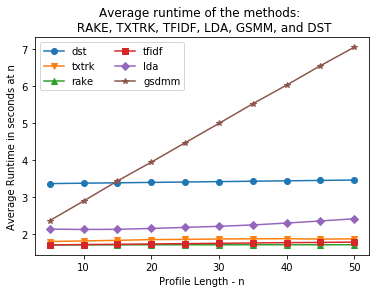

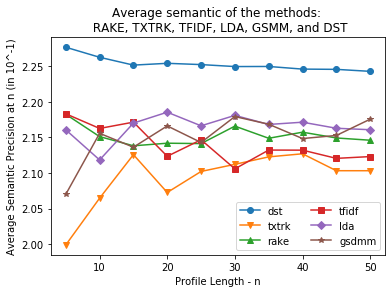

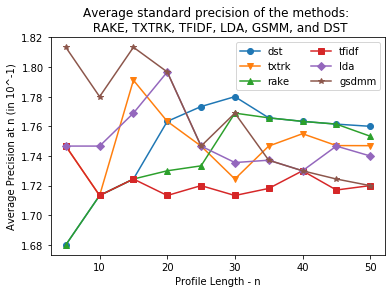

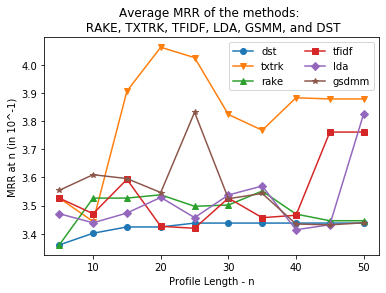

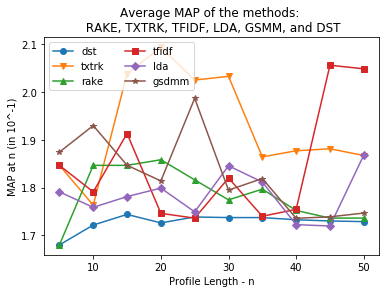

Time in hours:  0.008125450888441669
THE END !!!!


In [65]:
if __name__ == "__main__": 

    dataset = 'twitter_1196'         #argument
    fromID = 0                       #argument 
    toID = 19#fromID                    #argument    
    filename = "data/output/" + dataset + "/" + str(fromID) + ".json"
    
    hashtags_lst = [] #each element is of a given user
    dst_lst = []      #each element is of a given user
    txtrk_lst = []    #each element is of a given user
    rake_lst = []     #each element is of a given user
    tfidf_lst = []    #each element is of a given user
    lda_lst = []      #each element is of a given user
    gsdmm_lst = []    #each element is of a given user
    
    start_time = timeit.default_timer()
    for i in range (fromID, toID + 1):
        #1. Load data for all users
        hashtags, dst, txtrk, rake, tfidf, lda, gsdmm = load_data_from_file(filename)
        hashtags_lst.append(hashtags)
        dst_lst.append(dst)
        txtrk_lst.append(txtrk)
        rake_lst.append(rake)
        tfidf_lst.append(tfidf)
        lda_lst.append(lda)
        gsdmm_lst.append(gsdmm) 
        
        print("finished load for the user", i)
    
    #2. Calculate semantic precision
    avg_semantic_dst, avg_semantic_txtrk, avg_semantic_rake, avg_semantic_tfidf, avg_semantic_lda, avg_semantic_gsdmm = evaluate_semantic(dst_lst, txtrk_lst, rake_lst, tfidf_lst, lda_lst, gsdmm_lst, pretrained_model)
        
    #3. Calculate standard precision
    avg_precision_dst, avg_precision_txtrk, avg_precision_rake, avg_precision_tfidf, avg_precision_lda, avg_precision_gsdmm = evaluate_standard_precision(dst_lst, txtrk_lst, rake_lst, tfidf_lst, lda_lst, gsdmm_lst)


    #4. Calculate MRR
    mrr_dst, mrr_txtrk, mrr_rake, mrr_tfidf, mrr_lda, mrr_gsdmm = evaluate_MRR(dst_lst, txtrk_lst, rake_lst, tfidf_lst, lda_lst, gsdmm_lst)
    
    #5. Calculate MAP
    map_dst, map_txtrk, map_rake, map_tfidf, map_lda, map_gsdmm = evaluate_MAP(dst_lst, txtrk_lst, rake_lst, tfidf_lst, lda_lst, gsdmm_lst)

    #6. Calculate Runtime
    avg_rt_dst, avg_rt_txtrk, avg_rt_rake, avg_rt_tfidf, avg_rt_lda, avg_rt_gsdmm = evaluate_runtime(dst_lst, txtrk_lst, rake_lst, tfidf_lst, lda_lst, gsdmm_lst)
        
    #Plot the graph
    limit = 51 
    start = 5 
    step = 5
    
    #Runtime
    plot_graph_(avg_rt_dst, avg_rt_txtrk, avg_rt_rake, avg_rt_tfidf, avg_rt_lda, avg_rt_gsdmm,
                'Average runtime of the methods: \n RAKE, TXTRK, TFIDF, LDA, GSMM, and DST',
                limit, start, step)
    
    #Semantic
    plot_graph_(avg_semantic_dst, avg_semantic_txtrk, avg_semantic_rake, avg_semantic_tfidf, avg_semantic_lda, avg_semantic_gsdmm,
                'Average semantic of the methods: \n RAKE, TXTRK, TFIDF, LDA, GSMM, and DST',
                limit, start, step)
    
    #Standard precision
    plot_graph_(avg_precision_dst, avg_precision_txtrk, avg_precision_rake, avg_precision_tfidf, avg_precision_lda, avg_precision_gsdmm,
                'Average standard precision of the methods: \n RAKE, TXTRK, TFIDF, LDA, GSMM, and DST',
                limit, start, step)
    
    
    #MRR
    plot_graph_(mrr_dst, mrr_txtrk, mrr_rake, mrr_tfidf, mrr_lda, mrr_gsdmm,
                'Average MRR of the methods: \n RAKE, TXTRK, TFIDF, LDA, GSMM, and DST',
                limit, start, step)
    
    #MAP
    plot_graph_(map_dst, map_txtrk, map_rake, map_tfidf, map_lda, map_gsdmm,
                'Average MAP of the methods: \n RAKE, TXTRK, TFIDF, LDA, GSMM, and DST',
                limit, start, step)
    
    stop_time = timeit.default_timer()
    print('Time in hours: ', (stop_time - start_time)/3600)
    print("THE END !!!!")

# User visualization

In [57]:
#Predefined keywords on common topics: Education, Science and Technology, Entertainments, Politics, Economics
Education = ['email', 'grade', 'mark', 'process', 'passed', 'private', 'public', 'school', 'university', 'education', 'degree', 'class', 'lesson', 'lecture', 'classmate', 'course', 'teacher', 'student', 'classroom', 'online', 'computer', 'research', 'project', 'email', 'grade', 'mark', 'process', 'passed', 'private', 'public']
SciTech = ['apple', 'phone', 'mac', 'science', 'scientist', 'research', 'project', 'launch', 'introduce', 'market', 'camera', 'len', 'nano', 'technology', 'improvement', 'price', 'money', 'launch', 'function', 'app', 'introduce', 'competitors', 'advertisement']
Entertainment = ['music', 'song', 'sport', 'game', 'football', 'leage', 'champion', 'swimming', 'pool', 'computer', 'online', 'cinema', 'drame', 'travelling', 'sleep', 'walk', 'jogging', 'gym', 'eating', 'food', 'cusine', 'chat', 'shopping', 'cooking']
Politic = ['president', 'head', 'political', 'putin', 'russia', 'america', 'discrimination', 'immigration', 'europe', 'china', 'country', 'authority', 'choice', 'party', 'election', 'right', 'leader', 'area', 'politics', 'problem', 'vlardimir', 'people', 'opposition', 'minister', 'government', 'law', 'deputy', 'vice', 'state', 'military', 'white', 'house', 'beijing']
Economic = ['economic', 'grown', 'crisis', 'development', 'inflation', 'market', 'finance', 'demand', 'supply', 'tax', 'income', 'house', 'import', 'export', 'bankruptcy', 'interest', 'rate', 'compound', 'area', 'food', 'mall', 'chain', 'productivity', 'process', 'goods', 'country', 'student', 'car', 'transportation', 'train', 'flight', 'ticket']

#print(len(Education))
#print(len(SciTech))
#print(len(Entertainment))
#print(len(Politic))
#print(len(Economic))

def user_visualize(predefined_keywords, user_profile, pretrained_model):
    tmp_cosine = []
    for keyword in user_profile:
        for word in predefined_keywords:
            if word in pretrained_model and keyword in pretrained_model:
                tmp_cosine.append(my_cosine(np.array(pretrained_model[keyword]), 
                                        np.array(pretrained_model[word])))
                
    return np.mean(tmp_cosine)

def plot_subfigure(dst, txtrk, rake, tfidf, lda, limit, start, step):
    plt.clf()    
    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.2   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

   
    x = range(start, limit, step)
    #Plot first subfigure

    plt.subplot(1, 2, 1) #draw plot 1
    plt.plot(x, dst, marker='o', label = "Education")
    plt.plot(x, txtrk, marker='v', label = "Science & Technology")
    plt.plot(x, rake, marker='^', label = "Entertainments")
    plt.plot(x, tfidf, marker='s', label = "Politics")
    plt.plot(x, lda, marker='D', label = "Economics")
    plt.xlabel('Time step - t')
    plt.ylabel('User preferences of the topic at time t')
    
        
    #Plot second subfigure
    plt.subplot(1, 2, 2) #draw plot 2
    plt.plot(x, dst, marker='o', label = "Education")
    plt.plot(x, txtrk, marker='v', label = "Science & Technology")
    plt.plot(x, rake, marker='^', label = "Entertainments")
    plt.plot(x, tfidf, marker='s', label = "Politics")
    plt.plot(x, lda, marker='D', label = "Economics")
    
    plt.xlabel('Time step - t')
       
    plt.tight_layout(pad = 2.0)

    # Set a title of the current axes.
    plt.suptitle("User preferences on different topics at time t")
    
    # show a legend on the plot
    plt.legend(ncol=2)
    #save the figure
    plt.savefig('uv.pdf')
    #display a figure.
    plt.show()
    #close the figure
    plt.close()
    
    return 1

finished load for the user 0
len(education_lst) =  12


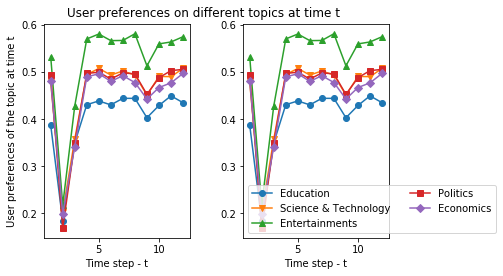

Time in hours:  0.000908297516612543
THE END !!!!


In [64]:
if __name__ == "__main__": 

    dataset = 'twitter_1196'         #argument
    fromID = 0                       #argument 
    toID = fromID                         #argument    
    
    hashtags_lst = [] #each element is of a given user
    dst_lst = []      #each element is of a given user
    txtrk_lst = []    #each element is of a given user
    rake_lst = []     #each element is of a given user
    tfidf_lst = []    #each element is of a given user
    lda_lst = []      #each element is of a given user
    gsdmm_lst = []    #each element is of a given user
    
    start_time = timeit.default_timer()
    for i in range (fromID, toID + 1):
        #if i == 1:
        #    continue
        
        #1. Load data for all users
        hashtags, dst, txtrk, rake, tfidf, lda, gsdmm = load_data_from_file(filename = "data/output/twitter_1196/" + str(i) + "_Day8.json")
        hashtags_lst.append(hashtags)
        dst_lst.append(dst)
        txtrk_lst.append(txtrk)
        rake_lst.append(rake)
        tfidf_lst.append(tfidf)
        lda_lst.append(lda)
        gsdmm_lst.append(gsdmm) 
        
        print("finished load for the user", i)
    
    #print("dst_lst = ", dst_lst)
    user_id = 0
    num_window_of_aUser = len(dst_lst[user_id])
    education_lst = []
    scitech_lst = []
    entertain_lst = []
    politic_lst = []
    economic_lst = []
    
    for j in range (0, num_window_of_aUser):
        #print("len() = ", len(dst_lst[i][j]))
        profile = dst_lst[user_id][j][0]
        education_lst.append(user_visualize(Education, profile, pretrained_model))
        scitech_lst.append(user_visualize(SciTech, profile, pretrained_model))
        entertain_lst.append(user_visualize(Entertainment, profile, pretrained_model))
        politic_lst.append(user_visualize(Politic, profile, pretrained_model))
        economic_lst.append(user_visualize(Economic, profile, pretrained_model))

    
    #Plot the graph
    print("len(education_lst) = ", len(education_lst))
    limit = len(education_lst) + 1
    start = 1 
    step = 1
    
    #Runtime
    #plot_graph_(entertain_lst, scitech_lst, education_lst, politic_lst, economic_lst, limit, start, step)
    plot_subfigure(entertain_lst, scitech_lst, education_lst, politic_lst, economic_lst, limit, start, step)
    
    stop_time = timeit.default_timer()
    print('Time in hours: ', (stop_time - start_time)/3600)
    print("THE END !!!!")